# Analogous bars: propagation study
* This notebook shows an application of the <b>similarity-centric analogous bars method</b> to compare barcodes from V1, orientation, and direction-sensitive neurons

#### Similarity-centric analogous bars
* <b> Inputs </b>:
    * Distance matrix among points in `P`
    * Distance matrix among points in `Q`
    * Corss-system distance matrix among `P` and `Q`.
* <b> Goal </b>:
    Given a selected bar in the Witness barcode `barcode(W(P,Q))`, find its representations in `barcode(VR(P))` and `barcode(VR(Q))`
* <b> Implementation </b>: 
    * Given a selected bar `bar_W_PQ` in `barcode(W(P,Q))`, apply Dowker's Theorem to find the corresponding bar `bar_W_QP` in `barcode(W(Q,P))`. 
    * Apply the bar-to-bars extension method to find the representation of `bar_W_PQ` in `barcode(VR(P))`.
    * Apply the bar-to-bars extension method second time to find the representation of `bar_W_QP` in `barcode(VR(Q))`.
    * All extension methds are implemented component-wise with $\mathbb{F}_2$ coefficients. We assume that all bars of barcodes have unique death times. 

#### Simulation data 
* `V1`: orientation x location conjunctive neurons. (S1 x S1 x S1)
* `O`: orientation neurons (S1)
* `D`: direction neurons (S1)
* The goal is to identify whether the S1's of `O` and `D` are encoded in `V1`

#### Contents 
1. Load points and visualize
2. Plot the four relevant barcodes
3. Run the similarity-centric analogous bars method
4. Explore cycle extension & bar extension under fixed interval decompositions of `barcode(VR(P))` and `barcode(VR(Q))`.
5. Explore alternative bar extensions under all possible interval decompositions of `barcode(VR(P))` and `barcode(VR(Q))`.

In [1]:
using Pkg
Pkg.activate("../../env/.")

  Activating project at `~/analogous_neural/env`


In [2]:
include("../../src/analogous_bars.jl")
include("../../src/Eirene_var.jl")

WebIO._IJuliaInit()

Main.Eirene_var

In [3]:
using .analogous_bars
using .Eirene_var
using DelimitedFiles
using Printf
using HDF5
using Random
using Plots
using JLD

In [4]:
directory = "data/"

"data/"

# 1. Propagation: V1 & orientation-sensitive neurons

## 1. Load distance matrices
* `V1`: 800 simulated V1 neurons
* `orientation`: 64 orientation-sensitive neurons

In [5]:
# load distances
directory = "data"
V1_distance = h5read(directory * "/V1_simulation_distance.h5", "distance")
O_distance = h5read(directory * "/orientation_distance.h5", "distance")
D_ori_V1 = h5read(directory * "/V1_orientation_distance.h5", "distance") 

# number of neurons
n_V1 = 800
n_O = 64

# convert vector of distances to distance matrix 
D_V1 = analogous_bars.vector_to_symmetric_matrix(V1_distance, n_V1)
D_O = analogous_bars.vector_to_symmetric_matrix(O_distance, n_O)
D_V1_ori = Array(transpose(D_ori_V1));

## 2. Compute persistence diagrams

Compute the usual (Vietoris-Rips) persistence diagrams

In [6]:
dim = 1

# VR persistence
VR_V1 = eirene(D_V1, record = "all", maxdim = dim)
VR_O = eirene(D_O, record = "all", maxdim = dim);

Compute the Witness persistence.  
<font color="red">Caution!! The following cell will take hours. One can instead load the relevant information from pre-computed files.</font>

In [ ]:
# Compute Witness persistence - this should take a few hours
W_ori_V1 = compute_Witness_persistence(D_ori_V1, maxdim = dim)
W_V1_ori = compute_Witness_persistence(D_V1_ori, maxdim = dim) 

LoadError: InterruptException:

In [ ]:
load(directory * "/W_V1_orientation_persistence.jld2")

In [94]:
# save Witness persistence info
#save(directory * "/W_orientation_V1_persistence.jld2", 
#    "eirene_output", W_ori_V1["eirene_output"],
#    "index2simplex", W_ori_V1["index2simplex"],
#    "W_vertex_to_defualt_vertex", W_ori_V1["W_vertex_to_default_vertex"])

#save(directory * "/W_V1_orientation_persistence.jld2", 
#    "eirene_output", W_V1_ori["eirene_output"],
#    "index2simplex", W_V1_ori["index2simplex"],
#    "W_vertex_to_defualt_vertex", W_V1_ori["W_vertex_to_default_vertex"])

In [7]:
# load pre-computed Witness persistence barcode
barcodes = load(directory *"/V1_orientation_baseline_similarity_analogous.jld2")["barcodes"]
barcode_W_ori_V1 = barcodes["W_orientation_V1"];


Plot persistence diagrams

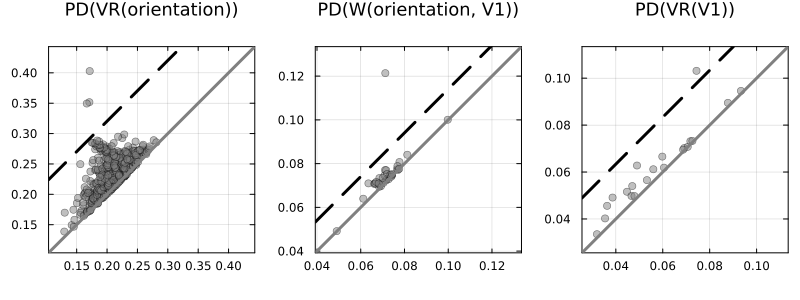

In [8]:
# get all barcodes
barcode_VR_V1 = barcode(VR_V1, dim = 1)
barcode_VR_O = barcode(VR_O, dim = 1)
#barcode_W_ori_V1 = barcode(C_W_orientation_V1, dim = dim) # or barcode(W_ori_V1["eirene_output"], dim = dim )

# plot all persistence diagrams & significance feature cutoff
selected_V1, cutoff_V1 = select_persistent_intervals_IQR(barcode_VR_V1)
p1 = plot_PD(barcode_VR_V1; cutoff = cutoff_V1,  title = "PD(VR(orientation))", titlefontsize = 12)

selected_W_ori_V1, cutoff_W_ori_V1 = select_persistent_intervals_IQR(barcode_W_ori_V1)
p2 = plot_PD(barcode_W_ori_V1; cutoff = cutoff_W_ori_V1, title = "PD(W(orientation, V1))", titlefontsize = 12)

selected_ori, cutoff_ori = select_persistent_intervals_IQR(barcode_VR_O)
p3 = plot_PD(barcode_VR_O; cutoff = cutoff_ori, title = "PD(VR(V1))", titlefontsize = 12)


p = plot(p1, p2, p3, layout = grid(1,3), size = (800, 300))
display(p)

## 3. Run similarity-centric analogous bars
* option (a): baseline similarity-centric analogous bars
* option (b): full (baseline & offset) similarity-centric analogous bars at epsilon_0
* option (c): full (baseline & offset) similarity-centric analogous bars at epsilon_0 using saved Witness persistence

### 3(a) baseline similarity-centric analogous bars

In [9]:
analogous_P, analogous_Q = analogous_bars.run_baseline_similarity_analogous(VR_P = VR_O,
                                                                            D_P = D_O,
                                                                            VR_Q = VR_V1,
                                                                            D_Q = D_V1,
                                                                            W_PQ = W_ori_V1,
                                                                            W_PQ_bars = selected_W_ori_V1,
                                                                            dim = 1);

LoadError: UndefVarError: `W_ori_V1` not defined

Plot the analogous pairs

In [86]:
# select Witness feature
i = 35 # must be a member of `selected_W_ori_V1`

p1 = plot_PD(barcode_VR_V1; 
    highlight = analogous_Q[i]["baseline_bar_extension"],
    cutoff = cutoff_V1,  
    title = "VR(V1)", 
    titlefontsize = 12)
p2 = plot_PD(barcode_W_ori_V1; 
    highlight = [i],
    cutoff = cutoff_W_ori_V1, 
    title = "W", 
    titlefontsize = 12)
p3 = plot_PD(barcode_VR_O; 
    highlight = analogous_P[i]["baseline_bar_extension"],
    cutoff = cutoff_ori, 
    title = "VR(orientation)", 
    titlefontsize = 12)

plot(p1, p2, p3, layout = grid(1,3), size = (800, 300))

<!DOCTYPE html>
 
 
 Plots.jl

In [44]:
# gather barcodes
barcodes = Dict()
barcodes["VR_V1"] = barcode_VR_V1
barcodes["VR_orientation"] = barcode_VR_O
barcodes["W_orientation_V1"] = barcode_W_ori_V1

# gather the persistence cutoff and selected bars
persistence_cutoff = Dict()
persistence_cutoff["V1_selected"] = selected_V1
persistence_cutoff["V1_cutoff"] = cutoff_V1
persistence_cutoff["ori_selected"] = selected_ori
persistence_cutoff["ori_cutoff"] = cutoff_ori
persistence_cutoff["W_ori_V1_selected"] = selected_W_ori_V1
persistence_cutoff["W_ori_V1_cutoff"] = cutoff_W_ori_V1;

# gather analogous pairs
analogous_pair = Dict()
analogous_pair[]

for i in selected_W_ori_V1
    pair_i = Dict()
    pair_i["order"] = ["orientation", "V1"]
    pair_i["baseline_bar_ext"] = [analogous_P[i]["baseline_bar_extension"], analogous_Q[i]["baseline_bar_extension"]]
    pair_i["epsilon_0"] = [analogous_P[i]["epsilon_0"], analogous_Q[i]["epsilon_0"]]
    pair_i["min_epsilon_with_boundary"] = [analogous_P[i]["min_epsilon_with_boundary"], analogous_Q[i]["min_epsilon_with_boundary"]]
    analogous_pair[i] = pair_i
end


In [46]:
# save output
"""
save(directory * "/V1_orientation_baseline_similarity_analogous.jld2", 
    "barcodes", barcodes,
    "persistence_cutoff", persistence_cutoff,
    "analogous_pair", analogous_pair)
"""

# 2. Direction study

## 1. Load distance matrices
* `V1`: 800 simulated V1 neurons
* `orientation`: 64 orientation-sensitive neurons

In [4]:
n_V1 = 800
n_D = 64

64

In [5]:
directory = "data"

"data"

In [6]:
# load distances
V1_distance = h5read(directory * "/V1_simulation_distance.h5", "distance")
direction_distance = h5read(directory * "/direction_distance.h5", "distance")
D_direction_V1 = h5read(directory * "/V1_direction_distance.h5", "distance") # this is probably orientation_V1 

# convert vector of distances to distance matrix 
D_V1 = vector_to_symmetric_matrix(V1_distance, n_V1)
D_direction = vector_to_symmetric_matrix(direction_distance, n_D)
D_V1_direction = Array(transpose(D_direction_V1))
# D_D = vector_to_symmetric_matrix(D_distance, n_D);

# 2. Plot barcodes

In [7]:
dim = 1

# VR persistence
VR_V1 = eirene(D_V1, record = "all", maxdim = dim)
VR_direction = eirene(D_direction, record = "all", maxdim = dim)

# Witness persistence
W_direction_V1 = compute_Witness_persistence(D_direction_V1, maxdim = 1);
C_W_direction_V1 = W_direction_V1["eirene_output"];
#W_V1_direction = compute_Witness_persistence(D_V1_direction, maxdim = dim);

In [16]:
# get all barcodes
barcode_VR_V1 = barcode(VR_V1, dim = 1)
barcode_VR_direction = barcode(VR_direction, dim = 1)
barcode_W_direction_V1 = barcode(C_W_direction_V1, dim = dim) # or barcode(W_ori_V1["eirene_output"], dim = dim )

# plot all persistence diagrams & significance feature cutoff
selected_V1, cutoff_V1 = select_persistent_intervals_IQR(barcode_VR_V1)
p1 = plot_PD(barcode_VR_V1; cutoff = cutoff_V1,  title = "Barcode(VR(direction))", titlefontsize = 12)

selected_W_direction_V1, cutoff_W_direction_V1 = select_persistent_intervals_IQR(barcode_W_direction_V1)
p2 = plot_PD(barcode_W_direction_V1; cutoff = cutoff_W_direction_V1, title = "Barcode(W(direction, V1))", titlefontsize = 12)

selected_direction, cutoff_direction = select_persistent_intervals_IQR(barcode_VR_direction)
p3 = plot_PD(barcode_VR_direction; cutoff = cutoff_direction, title = "Barcode(VR(direction))", titlefontsize = 12)


plot(p1, p2, p3, layout = grid(1,3), size = (800, 300))

<!DOCTYPE html>
 
 
 Plots.jl

There are no significant features in the Witness complex between. Hence, no analogous cycles.

In [14]:
# gather barcodes
barcodes = Dict()
barcodes["VR_V1"] = barcode_VR_V1
barcodes["VR_direction"] = barcode_VR_direction
barcodes["W_direction_V1"] = barcode_W_direction_V1

# gather the persistence cutoff and selected bars
persistence_cutoff = Dict()
persistence_cutoff["V1_selected"] = selected_V1
persistence_cutoff["V1_cutoff"] = cutoff_V1
persistence_cutoff["direction_selected"] = selected_direction
persistence_cutoff["direction_cutoff"] = cutoff_direction
persistence_cutoff["W_direction_V1_selected"] = selected_W_direction_V1
persistence_cutoff["W_direction_V1_cutoff"] = cutoff_W_direction_V1;

# save output
"""
save(directory * "/V1_direction_baseline_similarity_analogous.jld2", 
    "barcodes", barcodes,
    "persistence_cutoff", persistence_cutoff,
    "analogous_pair", nothing)
"""